# Experiment 1 Fixed Tilt

This journal supports the process of designing a solar panel configuration to appropriately represent ideal shading conditions for coffee production underneath elevated solar panels. 

The coffee trees would be under and/or in between elevated solar panels (panels would be elevated 6, 8, or 10 ft tall). The light/shade analysis helps determine appropriate panel heights and spacings t0 achieve appropriate shading.  The desired level of shading is maximum of 30% (i.e., 70% of normal, unshaded light). 

Details:
*  The coffee plants are expected to be \~5 ft tall. (5-6 ft tall and 3 ft wide (<a href="https://realgoodcoffeeco.com/blogs/realgoodblog/how-to-grow-a-coffee-plant-at-home#:~:text=However%2C%20you%20must%20keep%20in,tall%20and%203%20feet%20wide">Reference</a>)
*	Location: 18.202142, -66.759187; (18°12'07.7"N 66°45'33.1"W)
*	Desired area of initial analysis: 400-600 ft2 (37-55 m2)
*	Racking: Fixed-tilt panels
*	Panel size: 3.3 feet x 5.4 feet                                    (1m x 1.64m)
*	Analysis variations:
<ul> <li> a.	Panel height: would like to examine heights of 6 ft, 8 ft, and 10 ft hub height. 
<li> b.	Panel spacing (N/W): would like to look at multiple distances (e.g., 2 ft, 3 ft, 4 ft) </li> 
<li> c.	Inter-Row spacing (E/W): would like to look at multiple distances (e.g., 2 ft, 3 ft, 4 ft)! </li> 


Steps on this Journal:
<ol>
    <li> <a href='#step1'> <u><b>Loop to Raytrace and sample irradiance at where Three would be located </u></b></li>
    <li> <a href='#step2'> Calculate GHI for Comparisons </li>
        <ul><li> <a href='#step2a'> Option 1: Raytrace of Empty Field  </li></ul>
        <ul><li> <a href='#step2b'> Option 2: Weather File </li></ul>
    <li> <a href='#step3'> Compile Results </li>
    <li> <a href='#step4'> Plot Results</li>
    <li> <a href='#step5'> <u><b> Raytrace with Tree Geometry <u></b></li>
        <ul><li> <a href='#step5a'>Tree Parameters</li></ul>
        <ul><li> <a href='#step5b'>Loop to Raytrace and Sample Irradiance at Each side of the Tree (N, S, E, W)</li></ul>
        <ul><li> <a href='#step5c'>Single simulation until MakeOct for Getting a PRETTY IMAGE </li></ul>
    <li> <a href='#step6'> Compile Results</li>
    <li> <a href='#step7'>  Plot </li>

</ol>
        

        
![AgriPV Coffee Trees Simulation](../images_wiki/AdvancedJournals/AgriPV_CoffeeTrees.PNG)

 
While we have HPC scripts to do the below simulation, this journals runs all of the above so it might take some time, as there are 109 combinations of parameters explored

In [2]:
import bifacial_radiance
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bifacialvf

In [3]:
testfolder = str(Path().resolve().parent.parent / 'bifacial_radiance' / 'TEMP' /  'Experiment_1')
if not os.path.exists(testfolder):
    os.makedirs(testfolder)
    
resultsfolder = os.path.join(testfolder, 'results')

### General Parameters and Variables

In [4]:
ft2m = 0.3048
lat = 32.25
lon = -110.9  #Lat and Long for Tuscon Arizona           

# Constants
azimuth = 180 #cycling through 3 different azimuths                 
albedo = 0.31  # Changed from 0.31 for test 6/9/22
x = 1
y = 2 
xgap =  0.02
ygap = 0 # Meters
# D (meters)is a variable that represents the spacing between rows, not-considering the collector areas.
D = 2.8    
    
nMods = 20
nRows = 7
numpanels = 1
moduletype = 'test-module' #Need to make sure this is right module
hpc = False
sim_general_name = 'Rad_Experiment1'
CW = y * numpanels
    
#Arrays for loops
tilts = [20,30]  
clearance_heights = np.array([0.25,0.5,0.75,1,1.5,2]) # height/ collector width
GCRs = [0.28,0.33,0.4,0.6]

#Defaults
tilt_def = tilts[0]
clearance_height_def = clearance_heights[2]
GCR_def = GCRs[1]
pitch_def = CW/GCR_def




#width = nMods * x +(nMods-1)*(xgap)+2
#xinc = width / 14
#xstart = -width/2
#length = (4*y+(3*ygap))* np.cos(np.radians(tilt))*2+D+2
#ystart = length/1.328
#yinc = -length/9

print(pitch_def)

6.0606060606060606


In [6]:
starttime =pd.to_datetime('2021-10-01 01:00:0')
endtime = pd.to_datetime('2021-10-31 23:00:0')
demo = bifacial_radiance.RadianceObj(sim_general_name,str(testfolder)) 
demo.setGround(albedo)
epwfile = demo.getEPW(lat,lon)  
demo.readWeatherFile(epwfile, starttime=starttime, endtime=endtime, coerce_year = 2021) # Name and path
#metdata=demo.readWeatherFile(epwfile, starttime=starttime, endtime=endtime)
demo.genCumSky()
#else:
   #epwfile = r'EPWs\USA_WA_Ephrata.Muni.AP.727826_TMY3.epw' 
    #Not nespelem but close. How should I use the Nespelem weather file

path = C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1
Loading albedo, 1 value(s), 0.310 avg
1 nonzero albedo values.
Getting weather file: USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw
 ... OK!
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loaded  EPWs\metdata_temp.csv
message: Error!  Solar altitude is -7 < -6 degrees and Idh = 35 > 10 W/m^2 on day 289 !Ibn is 0.  Attempting to continue!
Error!  Solar altitude is -7 < -6 degrees and Idh = 35 > 10 W/m^2 on day 291 !Ibn is 0.  Attempting to continue!
Error!  Solar altitude is -7 < -6 degrees and Idh = 16 > 10 W/m^2 on day 291 !Ibn is 0.  Attempting to continue!
Error!  Solar altitude is -7 <

'skies\\cumulative.rad'

## 1. Create Geometry using gendaylit and view

In [6]:
starttime =pd.to_datetime('2003-06-01 01:00:0')
endtime = pd.to_datetime('2003-06-30 23:00:0')
demo = bifacial_radiance.RadianceObj(sim_general_name,str(testfolder)) 
demo.setGround(albedo)
epwfile = demo.getEPW(lat,lon)  
metdata=demo.readWeatherFile(epwfile, starttime=starttime, endtime=endtime)
timestamp = metdata.datetime.index(pd.to_datetime('2003-06-01 13:00:0 -8'))
demo.gendaylit(timestamp)  # Use this to simulate only one hour at a time.
azimuth_test = 180
pitch = pitch_def
sim_name = sim_general_name+'_az_'+str(round(azimuth,1))
module = demo.makeModule(name=moduletype, x=x, y=y,numpanels = numpanels, xgap=xgap, ygap=ygap)
sceneDict = {'tilt':tilt_def,'pitch':pitch,'clearance_height':clearance_height_def,'azimuth':azimuth_test,'nMods': nMods,'nRows': nRows}
scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
octfile = demo.makeOct(demo.getfilelist()) 
!rvu -vf views\front.vp -e .01 -pe 0.4 -vp 3.5 -20 22 Rad_Experiment1.oct

path = C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1
Loading albedo, 1 value(s), 0.310 avg
1 nonzero albedo values.
Getting weather file: USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw
 ... OK!
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2003
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos

Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created Rad_Experiment1.oct


## Setup length, width and sensors for scene

In [7]:
# Parameters for scene size and sensor starts
sensorsx_fb = [1,1]
sensorsy_fb = [4,6*numpanels]
#sensorsx_gb = [217,1] #217 for 10cm increase, originally 15
sensorsx_gb = [1,1] 
sensorsy_gb = [200,198] #122 for 10cm increase, originally 10
#width = nMods * x +(nMods-1)*(xgap)+2
#xinc = width / (sensorsx_gb[0] -1) 
#xstart = -width/2
#ystart = -length/4

print(sensorsx_gb)

[1, 1]


## Begining of Experiment. Part 1: Varying tilt

In [8]:
module = demo.makeModule(name=moduletype, x=x, y=y, xgap=xgap, ygap=ygap)
for ti in range (0, len(tilts)):
    #Build scene and run raytracing for all 3 azimuths
    tilt = tilts[ti]
    length = pitch_def*nRows+(y* np.cos(np.radians(tilt)))+2
    #ystart = length/1.328
    #yinc = length/9
    #yinc = -length/(sensorsy_gb[0]-1) 
    yinc = pitch_def/(sensorsy_gb[0]-1)
    writefiletitle = os.path.join(testfolder, 'Results_Test_Tilt_'+str(tilt)+'.csv')
    sim_name = sim_general_name+'_tilt_'+str(tilt)
    sceneDict = {'tilt':tilt,'pitch':pitch_def,'clearance_height':clearance_height_def,'azimuth':azimuth,'nMods': nMods,'nRows': nRows}
    if tilt == 20:
        scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
        octfile = demo.makeOct(demo.getfilelist())  
        analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
        frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
        groundscan = frontscan.copy() 
        #groundscan['xstart'] = xstart
        #groundscan['xinc'] = 0
        #groundscan['sx_xinc'] = xinc
        #groundscan['ystart'] = ystart
        groundscan['yinc'] = yinc
        groundscan['zstart'] = 0.05
        groundscan['zinc'] = 0
        groundscan['orient'] = '0 0 -1'
    scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
    octfile = demo.makeOct(demo.getfilelist())
    frontscan, backscan = analysis.moduleAnalysis(scene=scene, sensorsy=sensorsy_gb, sensorsx = sensorsx_gb)
    analysis.analysis(octfile, name=sim_name+'_Module_Analysis', frontscan=frontscan, backscan=backscan)
    analysis.analysis(octfile, name=sim_name+'_Ground_Analysis', frontscan=groundscan, backscan=backscan)
    


Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_tilt_20_Module_Analysis_Front
Linescan in process: Rad_Experiment1_tilt_20_Module_Analysis_Back
Saved: results\irr_Rad_Experiment1_tilt_20_Module_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_tilt_20_Module_Analysis_Back.csv
Linescan in process: Rad_Experiment1_tilt_20_Ground_Analysis_Front
Linescan in process: Rad_Experiment1_tilt_20_Ground_Analysis_Back
Saved: results\irr_Rad_Experiment1_tilt_20_Ground_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_tilt_20_Ground_Analysis_Back.csv
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_tilt_30_Module_Analysis_Front
Linescan in process: Rad_Experiment1_tilt_30_Module_Analysis_Back
Saved: results\irr_Rad_Experiment1_tilt_30_Module_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_til

## Ground Irradiance Tilt Comparison

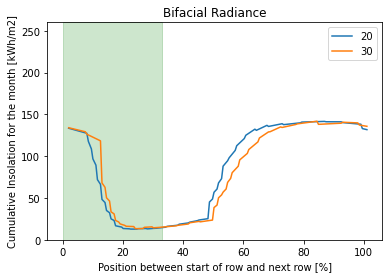

In [9]:
## Ground Irradiance Comparison
for ti in range (0, len(tilts)):
    tilt = tilts[ti]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_tilt_'+str(tilt)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)

    #Based on calculations, the points in the bifacial radiance file that correspond with the points in the bifacialvf
    # file are (0,-1) to (0,5.06). This is rows 13272 through 13256 (16 points) in the excel file. Will isolate these rows
    #data2.rename(columns={ data2.columns[0]: "x", data2.columns[1]: "y",data2.columns[2]: "z", data2.columns[3]: "mattype",
                       #data2.columns[4]: "Wm2Front",}, inplace = True)
    #print(data2)
    data_line = data2
    #data_line_f=np.flipud(data_line)
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #we're focused on later points.
    #print(data_line_f['Wm2Front'].min())

    xstep = (len(data_line_f))
    x_axis = list(range(1,101))
    x_axis_rad = np.linspace(0,100,xstep)
    #print(x_axis_rad)
    #print(x_axis) 
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch_def)*100
    #Rad = plt.plot(ystep, data_line_fR['Wm2Front']/1000, label='Rad (122)')
    plt.figure(1)
    #Radiance = plt.plot(x_shift,data_line_f['Wm2Front']/1000, label=tilt)
    Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label=tilt)
    plt.title('Bifacial Radiance')
    plt.ylim([0, 260])
    plt.axvspan(0, 33, alpha=.1, color='green')
    #plt.xlabel('Distance from lower edge of 1st row (m)')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for the month [kWh/m2]')
    plt.legend()
    top = data_line_f.loc[data_line_f['Wm2Front'] >220000]
   
    #Q In bifacial Radiacne is (0,0) the middle of the module or the bottom edge

## Find percent differences betweem Radiance and VF

In [11]:
for ti in range (0, len(tilts)):
    tilt = tilts[ti]
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_tilt_'+str(tilt)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2 
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #Isolate rows with Wm2Front values over 200,000
    top = data_line_f.loc[data_line_f['Wm2Front'] >130000]
    #Average rows for average of max
    maxave = np.mean(top['Wm2Front'])
    #Find Minimum of plot
    minpoint=np.min(data_line_f['Wm2Front'])
    #Find midpoint of pot
    Mid = (maxave-minpoint)/2
    print('Rad Mid',Mid)
    Midr = Mid + minpoint
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    line = data_line_f.loc[data_line_f['Wm2Front'] < Midr]
    #Average these for the average for Radiance
    Radave = np.mean(line['Wm2Front'])
    print('Average Radiance is',Radave)

    #Do the Same for Bifacial VF
    (data, metadata) = loadVFresults(r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_Tilt_'+str(tilt)+'.csv')
    #Work with data in resultfile
    data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
    # I'm sure there's a fancier way to do this but hey, this works.
    df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

                       df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
                       df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)
    topvf = df.loc[df['Oct'] >130000]
    #Average rows for average of max
    maxavevf = np.mean(topvf['Oct'])
    #Find Minimum of plot
    minpointvf=np.min(df['Oct'])
    #Find midpoint of pot
    Midvf = (maxavevf-minpointvf)/2
    print('VF mid',Midvf)
    Midrvf = Midvf + minpointvf
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    linevf = df.loc[df['Oct'] < Midrvf]
    #Average these for the average for Radiance
    VFave = np.mean(linevf['Oct'])
    print('Average VF is',VFave)

    Pdif = abs((Radave-VFave)/((Radave+VFave)/2)*100)
    print('For tilt =',tilt,'difference is',Pdif,'%')

Rad Mid 62552.01524096387
Average Radiance is 25229.486626506023
VF mid 59467.464096256095
Average VF is 25770.595451381178
For tilt = 20 difference is 2.121991976596331 %
Rad Mid 61935.16932432433
Average Radiance is 26196.264999999996
VF mid 59231.66877842402
Average VF is 25546.04063301589
For tilt = 30 difference is 2.5133181021960778 %


## Back of Module Comparison

C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_tilt_20_Ground_Analysis_Back.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_tilt_30_Ground_Analysis_Back.csv


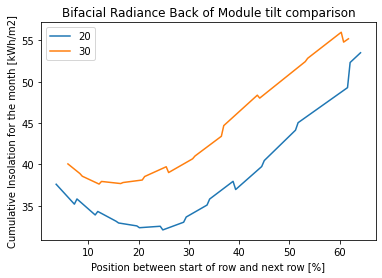

In [189]:
## Back of Module Comparison
for ti in range (0, len(tilts)):
    tilt = tilts[ti]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_tilt_'+str(tilt)+'_Ground_Analysis_Back.csv'
    print(Radiance_File)
    (data2, metadata) = loadVFresults(Radiance_File)

    #Based on calculations, the points in the bifacial radiance file that correspond with the points in the bifacialvf
    # file are (0,-1) to (0,5.06). This is rows 13272 through 13256 (16 points) in the excel file. Will isolate these rows
    #data2.rename(columns={ data2.columns[0]: "x", data2.columns[1]: "y",data2.columns[2]: "z", data2.columns[3]: "mattype",
                       #data2.columns[4]: "Wm2Front",}, inplace = True)
    #print(data2)
    data_line = data2#.iloc[13253:13269] #Account for the three lines ignored in the loadVFresults command. Don't need them since 
    #data_line_f=np.flipud(data_line)
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Back",}, inplace = True)
    #we're focused on later points.
    #print(data_line_f['Wm2Front'].min())

    xstep = (len(data_line_f))
    x_axis = list(range(1,101))
    x_axis_rad = np.linspace(0,100,xstep)
    #print(x_axis_rad)
    #print(x_axis) 
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/CW)*100
    #Rad = plt.plot(ystep, data_line_fR['Wm2Front']/1000, label='Rad (122)')
    plt.figure(1)
    #Radiance = plt.plot(x_shift,data_line_f['Wm2Front']/1000, label=tilt)
    Radiance = plt.plot(ystep,data_line_f['Wm2Back']/1000, label=tilt)
    plt.title('Bifacial Radiance Back of Module tilt comparison')
    #plt.xlabel('Distance from lower edge of 1st row (m)')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for the month [kWh/m2]')
    plt.legend()
    #Q In bifacial Radiacne is (0,0) the middle of the module or the bottom edge

##  Part 2: Varying Clearance Height

In [12]:
module = demo.makeModule(name=moduletype, x=x, y=y, xgap=xgap, ygap=ygap)
for ch in range (0, len(clearance_heights)):
    #Build scene and run raytracing for all 3 azimuths
    clearance_height = clearance_heights[ch]
    length = pitch_def*nRows+(y* np.cos(np.radians(tilt_def)))+2
    #ystart = length/1.328
    #yinc = length/9
    yinc = pitch_def/(sensorsy_gb[0]-1)
    writefiletitle = os.path.join(testfolder, 'Results_Test_ClearanceHeight_'+str(clearance_height)+'.csv')
    sim_name = sim_general_name+'_ClearanceHeight_'+str(clearance_height)
    sceneDict = {'tilt':tilt_def,'pitch':pitch_def,'clearance_height':clearance_height,'azimuth':azimuth,'nMods': nMods,'nRows': nRows}
    if tilt_def == 20:
        scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
        octfile = demo.makeOct(demo.getfilelist())  
        analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
        frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
        groundscan = frontscan.copy() 
        #groundscan['xstart'] = xstart
        #groundscan['xinc'] = 0
        #groundscan['sx_xinc'] = xinc
        #groundscan['ystart'] = ystart
        groundscan['yinc'] = yinc
        groundscan['zstart'] = 0.05
        groundscan['zinc'] = 0
        groundscan['orient'] = '0 0 -1'
    scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
    octfile = demo.makeOct(demo.getfilelist())
    frontscan, backscan = analysis.moduleAnalysis(scene=scene, sensorsy=sensorsy_gb, sensorsx = sensorsx_gb)
    analysis.analysis(octfile, name=sim_name+'_Module_Analysis', frontscan=frontscan, backscan=backscan)
    analysis.analysis(octfile, name=sim_name+'_Ground_Analysis', frontscan=groundscan, backscan=backscan)


Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_ClearanceHeight_0.25_Module_Analysis_Front
Linescan in process: Rad_Experiment1_ClearanceHeight_0.25_Module_Analysis_Back
Saved: results\irr_Rad_Experiment1_ClearanceHeight_0.25_Module_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_ClearanceHeight_0.25_Module_Analysis_Back.csv
Linescan in process: Rad_Experiment1_ClearanceHeight_0.25_Ground_Analysis_Front
Linescan in process: Rad_Experiment1_ClearanceHeight_0.25_Ground_Analysis_Back
Saved: results\irr_Rad_Experiment1_ClearanceHeight_0.25_Ground_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_ClearanceHeight_0.25_Ground_Analysis_Back.csv
Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_ClearanceHeight_0.5_Module_Analysis_Front
Linescan in process: Rad_Expe

## Ground Irradiance Clearance Height Comparison

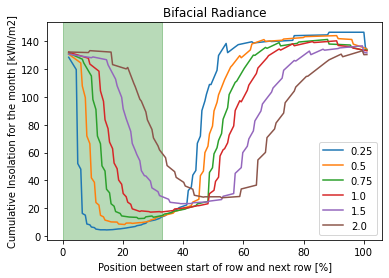

In [16]:
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_'+str(clearance_height)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)

    #Based on calculations, the points in the bifacial radiance file that correspond with the points in the bifacialvf
    # file are (0,-1) to (0,5.06). This is rows 13272 through 13256 (16 points) in the excel file. Will isolate these rows
    #data2.rename(columns={ data2.columns[0]: "x", data2.columns[1]: "y",data2.columns[2]: "z", data2.columns[3]: "mattype",
                       #data2.columns[4]: "Wm2Front",}, inplace = True)
    #print(data2)
    data_line = data2#.iloc[13253:13269] #Account for the three lines ignored in the loadVFresults command. Don't need them since 
    #data_line_f=np.flipud(data_line)
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #we're focused on later points.
    #print(data_line_f['Wm2Front'].min())

    xstep = (len(data_line_f))
    x_axis = list(range(1,101))
    x_axis_rad = np.linspace(0,100,xstep)
    #print(x_axis_rad)
    #print(x_axis)
   
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch_def)*100
    module_end = (2/pitch_def)*100 #Percentage between rows where the module ends)
    plt.figure(1)
    #Radiance = plt.plot(x_axis_rad,data_line_f['Wm2Front']/1000, label=clearance_height)
    Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label=clearance_height)
    plt.title('Bifacial Radiance')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for the month [kWh/m2]')
    plt.axvspan(0, module_end, alpha=.05, color='green')
    plt.legend()
    #Q In bifacial Radiacne is (0,0) the middle of the module or the bottom edge

## VF and Radiance Clearance Height Percent Differences

In [15]:
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_'+str(clearance_height)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2 
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #Isolate rows with Wm2Front values over 200,000
    top = data_line_f.loc[data_line_f['Wm2Front'] >130000]
    #Average rows for average of max
    maxave = np.mean(top['Wm2Front'])
    #Find Minimum of plot
    minpoint=np.min(data_line_f['Wm2Front'])
    #Find midpoint of pot
    Mid = (maxave-minpoint)/2
    Midr = Mid + minpoint
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    line = data_line_f.loc[data_line_f['Wm2Front'] < Midr]
    #Average these for the average for Radiance
    Radave = np.mean(line['Wm2Front'])
    #print('Average Radiance is',Radave)

    #Do the Same for Bifacial VF
    (data, metadata) = loadVFresults(r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_ClearanceHeight_'+str(clearance_height)+'.csv')
    #Work with data in resultfile
    data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
    # I'm sure there's a fancier way to do this but hey, this works.
    df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

                       df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
                       df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)
    topvf = df.loc[df['Oct'] >130000]
    #Average rows for average of max
    maxavevf = np.mean(topvf['Oct'])
    #Find Minimum of plot
    minpointvf=np.min(df['Oct'])
    #Find midpoint of pot
    Midvf = (maxavevf-minpointvf)/2
    Midrvf = minpointvf + Midvf
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    linevf = df.loc[df['Oct'] < Midrvf]
    #Average these for the average for Radiance
    VFave = np.mean(linevf['Oct'])
    #print('Average VF is',VFave)

    Pdif = abs((Radave-VFave)/((Radave+VFave)/2)*100)
    print('For Clearance Height =',clearance_height,'difference is',Pdif,'%')

For Clearance Height = 0.25 difference is 38.48131694133144 %
For Clearance Height = 0.5 difference is 26.92486865734137 %
For Clearance Height = 0.75 difference is 35.72257815371132 %
For Clearance Height = 1.0 difference is 34.3773550717378 %
For Clearance Height = 1.5 difference is 34.55883994903221 %
For Clearance Height = 2.0 difference is 34.94242750938793 %


## Back of Module Clearance Height Comparison

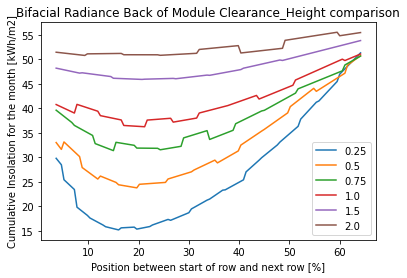

In [193]:
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_'+str(clearance_height)+'_Ground_Analysis_Back.csv'
    (data2, metadata) = loadVFresults(Radiance_File)

    #Based on calculations, the points in the bifacial radiance file that correspond with the points in the bifacialvf
    # file are (0,-1) to (0,5.06). This is rows 13272 through 13256 (16 points) in the excel file. Will isolate these rows
    #data2.rename(columns={ data2.columns[0]: "x", data2.columns[1]: "y",data2.columns[2]: "z", data2.columns[3]: "mattype",
                       #data2.columns[4]: "Wm2Front",}, inplace = True)
    #print(data2)
    data_line = data2#.iloc[13253:13269] #Account for the three lines ignored in the loadVFresults command. Don't need them since 
    #data_line_f=np.flipud(data_line)
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Back",}, inplace = True)
    #we're focused on later points.
    #print(data_line_f['Wm2Front'].min())

    xstep = (len(data_line_f))
    x_axis = list(range(1,101))
    x_axis_rad = np.linspace(0,100,xstep)
    #print(x_axis_rad)
    #print(x_axis) 
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/CW)*100
    #Rad = plt.plot(ystep, data_line_fR['Wm2Front']/1000, label='Rad (122)')
    plt.figure(1)
    #Radiance = plt.plot(x_shift,data_line_f['Wm2Front']/1000, label=tilt)
    Radiance = plt.plot(ystep,data_line_f['Wm2Back']/1000, label=clearance_height)
    plt.title('Bifacial Radiance Back of Module Clearance_Height comparison')
    #plt.xlabel('Distance from lower edge of 1st row (m)')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for the month [kWh/m2]')
    plt.legend()
    #Q In bifacial Radiacne is (0,0) the middle of the module or the bottom edge

## Part 3 Varying GCR

In [18]:
module = demo.makeModule(name=moduletype, x=x, y=y, xgap=xgap, ygap=ygap)
for gc in range (0, len(GCRs)):
    #Build scene and run raytracing for all 3 azimuths
    GCR = GCRs[gc]
    pitch = CW/GCR
    length = pitch*nRows+(y* np.cos(np.radians(tilt_def)))+2
    #ystart = length/1.328
    #yinc = length/9
    #yinc = -length/(sensorsy_gb[0]-1) 
    yinc = pitch/(sensorsy_gb[0]-1) 
    writefiletitle = os.path.join(testfolder, 'Results_Test_GCR_'+str(GCR)+'.csv')
    sim_name = sim_general_name+'_GCR_'+str(GCR)
    sceneDict = {'tilt':tilt_def,'pitch':pitch,'clearance_height':clearance_height_def,'azimuth':azimuth,'nMods': nMods,'nRows': nRows}
    if tilt_def == 20:
        scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
        octfile = demo.makeOct(demo.getfilelist())  
        analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
        frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
        groundscan = frontscan.copy() 
        #groundscan['xstart'] = xstart
        #groundscan['xinc'] = 0
        #groundscan['sx_xinc'] = xinc
        #groundscan['ystart'] = ystart
        groundscan['yinc'] = yinc
        groundscan['zstart'] = 0.05
        groundscan['zinc'] = 0
        groundscan['orient'] = '0 0 -1'
    scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
    octfile = demo.makeOct(demo.getfilelist())
    frontscan, backscan = analysis.moduleAnalysis(scene=scene, sensorsy=sensorsy_gb, sensorsx = sensorsx_gb)
    analysis.analysis(octfile, name=sim_name+'_Module_Analysis', frontscan=frontscan, backscan=backscan)
    analysis.analysis(octfile, name=sim_name+'_Ground_Analysis', frontscan=groundscan, backscan=backscan)


Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_GCR_0.28_Module_Analysis_Front
Linescan in process: Rad_Experiment1_GCR_0.28_Module_Analysis_Back
Saved: results\irr_Rad_Experiment1_GCR_0.28_Module_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_GCR_0.28_Module_Analysis_Back.csv
Linescan in process: Rad_Experiment1_GCR_0.28_Ground_Analysis_Front
Linescan in process: Rad_Experiment1_GCR_0.28_Ground_Analysis_Back
Saved: results\irr_Rad_Experiment1_GCR_0.28_Ground_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_GCR_0.28_Ground_Analysis_Back.csv
Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_GCR_0.33_Module_Analysis_Front
Linescan in process: Rad_Experiment1_GCR_0.33_Module_Analysis_Back
Saved: results\irr_Rad_Experiment1_GCR_0.33_Module_Analysis_Front.csv

## Ground Irradiance GCR Comparison

C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_0.28_Ground_Analysis_Front.csv
53.87938524157182
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_0.33_Ground_Analysis_Front.csv
46.30362766581424
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_0.4_Ground_Analysis_Front.csv
38.87938524157182
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_0.6_Ground_Analysis_Front.csv
27.212718574905153


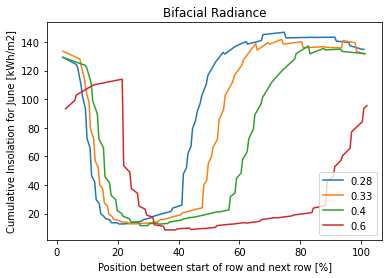

In [23]:
for gc in range (0, len(GCRs)):
    GCR = GCRs[gc]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_'+str(GCR)+'_Ground_Analysis_Front.csv'
    print(Radiance_File)
    (data2, metadata) = loadVFresults(Radiance_File)
    
    pitch = CW/GCR
    module_end = (2/pitch)*100 #Percentage between rows where the module ends)
    #print(yinc)
    #print(pitch)
    length = pitch*nRows+(y* np.cos(np.radians(tilt_def)))+2
    print(length)
    yinc = -length/(sensorsy_gb[0]-1)
    #s_point= round(13254 + (pitch/yinc)*-1)
    #start_point = round(13270 + (pitch/yinc))
    
    #Based on calculations, the points in the bifacial radiance file that correspond with the points in the bifacialvf
    # file are (0,-1) to (0,5.06). This is rows 13272 through 13256 (16 points) in the excel file. Will isolate these rows
    #data2.rename(columns={ data2.columns[0]: "x", data2.columns[1]: "y",data2.columns[2]: "z", data2.columns[3]: "mattype",                   #data2.columns[4]: "Wm2Front",}, inplace = True)
    #data_line = data2.iloc[13254:s_point] #Account for the three lines ignored in the loadVFresults command. Don't need them since 
    data_line = data2#.iloc[start_point:13270] #Account for the three lines ignored in the loadVFresults command. Don't need them since 
    #print(data_line)
    #data_line_f=np.flipud(data_line)
    data_line_f = data_line[::-1].reset_index(drop = True) #Flip the column
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #we're focused on later points.
    #print(data_line_f)
    #print(data_line_f['Wm2Front'].min())

    xstep = (len(data_line_f))
    #print(xstep)
    x_axis = list(range(1,101))
    x_axis_rad = np.linspace(0,100,xstep)
    #print(x_axis_rad)
    #print(x_axis)
    
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch)*100

    plt.figure(1)
    #Radiance = plt.plot(x_axis_rad,data_line_f['Wm2Front']/1000, label=GCR)
    Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label=GCR)
    plt.title('Bifacial Radiance')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for June [kWh/m2]')
    #plt.axvspan(0, module_end, alpha=.1, color='green')
    plt.legend()
    #Q In bifacial Radiacne is (0,0) the middle of the module or the bottom edge

## VF and Radiance GCR Percent Difference

In [22]:
for gc in range (0, len(GCRs)):
    GCR = GCRs[gc]
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_'+str(GCR)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2 
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #Isolate rows with Wm2Front values over 200,000
    top = data_line_f.loc[data_line_f['Wm2Front'] >125000]
    #Average rows for average of max
    maxave = np.mean(top['Wm2Front'])
    #Find Minimum of plot
    minpoint=np.min(data_line_f['Wm2Front'])
    #Find midpoint of pot
    Mid = (maxave-minpoint)/2
    Midr = Mid + minpoint
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    line = data_line_f.loc[data_line_f['Wm2Front'] < Midr]
    #Average these for the average for Radiance
    Radave = np.mean(line['Wm2Front'])
    #print('Average Radiance is',Radave)

    #Do the Same for Bifacial VF
    (data, metadata) = loadVFresults(r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_GCR_'+str(GCR)+'.csv')
    #Work with data in resultfile
    data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
    # I'm sure there's a fancier way to do this but hey, this works.
    df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

                       df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
                       df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)
    topvf = df.loc[df['Oct'] >125000]
    #Average rows for average of max
    maxavevf = np.mean(topvf['Oct'])
    #Find Minimum of plot
    minpointvf=np.min(df['Oct'])
    #Find midpoint of pot
    Midvf = (maxavevf-minpointvf)/2
    Midrvf = Midvf + minpointvf
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    linevf = df.loc[df['Oct'] < Midrvf]
    #Average these for the average for Radiance
    VFave = np.mean(linevf['Oct'])
    #print('Average VF is',VFave)

    Pdif = (Radave-VFave)/((Radave+VFave)/2)*100
    print('For GCR =',GCR,'difference is',Pdif,'%')

For GCR = 0.28 difference is 38.361560087269254 %
For GCR = 0.33 difference is 38.97162820396326 %
For GCR = 0.4 difference is 25.157494394967895 %
For GCR = 0.6 difference is nan %


## Back of Module GCR Comparison

C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_0.28_Ground_Analysis_Back.csv
78.87938524157181
10.714285714285714
-0.6518957457981142
-16
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_0.33_Ground_Analysis_Back.csv
67.51574887793544
9.09090909090909
-0.5579813956854168
-16
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_0.4_Ground_Analysis_Back.csv
56.37938524157182
7.5
-0.4659453325749737
-16
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_0.6_Ground_Analysis_Back.csv
38.87938524157182
5.0
-0.32131723340142
-16


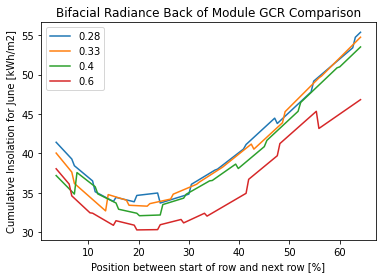

In [195]:
for gc in range (0, len(GCRs)):
    GCR = GCRs[gc]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_'+str(GCR)+'_Ground_Analysis_Back.csv'
    print(Radiance_File)
    (data2, metadata) = loadVFresults(Radiance_File)
    
    pitch = CW/GCR
    #print(yinc)
    #print(pitch)
    length = pitch*nRows+(y* np.cos(np.radians(tilt_def)))+2
    print(length)
    yinc = -length/(sensorsy_gb[0]-1)
    #s_point= round(13254 + (pitch/yinc)*-1)
    #start_point = round(13270 + (pitch/yinc))
    print(pitch)
    print(yinc)
    print(round(pitch/yinc))
    
    #Based on calculations, the points in the bifacial radiance file that correspond with the points in the bifacialvf
    # file are (0,-1) to (0,5.06). This is rows 13272 through 13256 (16 points) in the excel file. Will isolate these rows
    #data2.rename(columns={ data2.columns[0]: "x", data2.columns[1]: "y",data2.columns[2]: "z", data2.columns[3]: "mattype",                   #data2.columns[4]: "Wm2Front",}, inplace = True)
    #data_line = data2.iloc[13254:s_point] #Account for the three lines ignored in the loadVFresults command. Don't need them since 
    data_line = data2#.iloc[start_point:13270] #Account for the three lines ignored in the loadVFresults command. Don't need them since 
    #print(data_line)
    #data_line_f=np.flipud(data_line)
    data_line_f = data_line[::-1].reset_index(drop = True) #Flip the column
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #we're focused on later points.
    #print(data_line_f)
    #print(data_line_f['Wm2Front'].min())

    xstep = (len(data_line_f))
    #print(xstep)
    x_axis = list(range(1,101))
    x_axis_rad = np.linspace(0,100,xstep)
    #print(x_axis_rad)
    #print(x_axis)
    
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/CW)*100

    plt.figure(1)
    #Radiance = plt.plot(x_axis_rad,data_line_f['Wm2Front']/1000, label=GCR)
    Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label=GCR)
    plt.title('Bifacial Radiance Back of Module GCR Comparison')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for June [kWh/m2]')
    plt.legend()
    #Q In bifacial Radiacne is (0,0) the middle of the module or the bottom edge

## Part 4 Varying Y Gaps

In [24]:
xl = 2
yl = 1 
ygaps = [0,.1,.2,.3,.5,1]
numpanels_l = 2
for yg in range (0, len(ygaps)):
     #Build scene and run raytracing for all 3 azimuths
    ygap = ygaps[yg]
    module = demo.makeModule(name=moduletype, x=xl, y=yl,numpanels = numpanels_l, xgap=xgap, ygap=ygap)
    CW = yl * numpanels_l +(ygap * (numpanels_l-1)) #Collector Width
    pitch = CW/GCR_def
    length = pitch*nRows+(y* np.cos(np.radians(tilt_def)))+2
    #ystart = length/1.328
    #yinc = length/9
    #yinc = -length/(sensorsy_gb[0]-1) 
    yinc = pitch/(sensorsy_gb[0]-1) 
    writefiletitle = os.path.join(testfolder, 'Results_Test_Ygap_'+str(ygap)+'.csv')
    sim_name = sim_general_name+'_Ygap_'+str(ygap)
    sceneDict = {'tilt':tilt_def,'pitch':pitch,'clearance_height':clearance_height_def,'azimuth':azimuth,'nMods': nMods,'nRows': nRows}
    if tilt_def == 20:
        scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
        octfile = demo.makeOct(demo.getfilelist())  
        analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
        frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
        groundscan = frontscan.copy() 
        #groundscan['xstart'] = xstart
        #groundscan['xinc'] = 0
        #groundscan['sx_xinc'] = xinc
        #groundscan['ystart'] = ystart
        groundscan['yinc'] = yinc
        groundscan['zstart'] = 0.05
        groundscan['zinc'] = 0
        groundscan['orient'] = '0 0 -1'
    scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
    octfile = demo.makeOct(demo.getfilelist())
    frontscan, backscan = analysis.moduleAnalysis(scene=scene, sensorsy=sensorsy_gb, sensorsx = sensorsx_gb) #Change x and y sensors to match if you want to autogenerate front/back ratio
    analysis.analysis(octfile, name=sim_name+'_Module_Analysis', frontscan=frontscan, backscan=backscan)
    analysis.analysis(octfile, name=sim_name+'_Ground_Analysis', frontscan=groundscan, backscan=backscan)


Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_Ygap_0_Module_Analysis_Front
Linescan in process: Rad_Experiment1_Ygap_0_Module_Analysis_Back
Saved: results\irr_Rad_Experiment1_Ygap_0_Module_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_Ygap_0_Module_Analysis_Back.csv
Linescan in process: Rad_Experiment1_Ygap_0_Ground_Analysis_Front
Linescan in process: Rad_Experiment1_Ygap_0_Ground_Analysis_Back
Saved: results\irr_Rad_Experiment1_Ygap_0_Ground_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_Ygap_0_Ground_Analysis_Back.csv

Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_Ygap_0.1_Module_Analysis_Front
Linescan in proc

## Compare ground Irradiances

C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0_Ground_Analysis_Front.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0.1_Ground_Analysis_Front.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0.2_Ground_Analysis_Front.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0.3_Ground_Analysis_Front.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0.5_Ground_Analysis_Front.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_1_Ground_Analysis_Front.csv


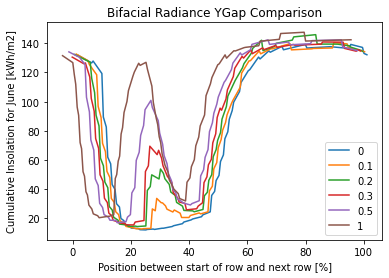

In [25]:
for yg in range (0, len(ygaps)):
    ygap = ygaps[yg]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_'+str(ygap)+'_Ground_Analysis_Front.csv'
    print(Radiance_File)
    (data2, metadata) = loadVFresults(Radiance_File)
    
    CW = yl * numpanels_l +(ygap * (numpanels_l-1)) #Collector Width
    pitch = CW/GCR_def
    
    #pitch = CW/GCR
    #print(yinc)
    #print(pitch)
    #length = pitch*nRows+(y* np.cos(np.radians(tilt_def)))+2
    #print(length)
    #yinc = -length/(sensorsy_gb[0]-1)
    #s_point= round(13254 + (pitch/yinc)*-1)
    #start_point = round(13270 + (pitch/yinc))
    #print(pitch)
    #print(yinc)
    #print(round(pitch/yinc))
    
    #Based on calculations, the points in the bifacial radiance file that correspond with the points in the bifacialvf
    # file are (0,-1) to (0,5.06). This is rows 13272 through 13256 (16 points) in the excel file. Will isolate these rows
    #data2.rename(columns={ data2.columns[0]: "x", data2.columns[1]: "y",data2.columns[2]: "z", data2.columns[3]: "mattype",                   #data2.columns[4]: "Wm2Front",}, inplace = True)
    #data_line = data2.iloc[13254:s_point] #Account for the three lines ignored in the loadVFresults command. Don't need them since 
    data_line = data2#.iloc[start_point:13270] #Account for the three lines ignored in the loadVFresults command. Don't need them since 
    #print(data_line)
    #data_line_f=np.flipud(data_line)
    data_line_f = data_line[::-1].reset_index(drop = True) #Flip the column
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #we're focused on later points.
    #print(data_line_f)
    #print(data_line_f['Wm2Front'].min())

    xstep = (len(data_line_f))
    #print(xstep)
    x_axis = list(range(1,101))
    x_axis_rad = np.linspace(0,100,xstep)
    #print(x_axis_rad)
    #print(x_axis)
    
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch)*100

    plt.figure(1)
    #Radiance = plt.plot(x_axis_rad,data_line_f['Wm2Front']/1000, label=GCR)
    Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label=ygap)
    plt.title('Bifacial Radiance YGap Comparison')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for June [kWh/m2]')
    plt.legend()
    #Q In bifacial Radiacne is (0,0) the middle of the module or the bottom edge

## Average YGap comparison

In [27]:
xl = 2
yl = 1 
ygaps = [0,.1,.2,.3,.5,1]
numpanels_l = 2
for yg in range (0, len(ygaps)):
    ygap = ygaps[yg]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_'+str(ygap)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2 
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #Isolate rows with Wm2Front values over 200,000
    top = data_line_f.loc[data_line_f['Wm2Front'] >130000]
    #Average rows for average of max
    maxave = np.mean(top['Wm2Front'])
    #Find Minimum of plot
    minpoint=np.min(data_line_f['Wm2Front'])
    #Find midpoint of pot
    Mid = (maxave-minpoint)/2
    Midr = Mid + minpoint
    #print('Mid is', Mid)
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    line = data_line_f.loc[data_line_f['Wm2Front'] < Midr]
    #print(line)
    #Find last point
    last = line.iloc[0]
    #print(last)
    #return row number of the last point
    lp = line[line['y'] == last['y']].index[0]
    #print(lp)
    #Make matrx of al points before last point
    #Make matrix of all points from 0 to last point
    merge = data_line_f.iloc[lp:]
    #print(merge)
    #Average these for the average for Radiance
    Radave = np.mean(merge['Wm2Front'])
    #print('Average Radiance for', ygap,'is',Radave)

    #Do the Same for Bifacial VF
    CW = yl * numpanels_l +(ygap * (numpanels_l-1)) #Collector Width
    AA = yl*numpanels_l #Area of module that light hits
    transFactor = 1 - (AA/CW) # TransmissionFactor(open area fraction)
    (data, metadata) = loadVFresults(r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_TFactor_'+str(transFactor)+'.csv')
    #Work with data in resultfile
    data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
    # I'm sure there's a fancier way to do this but hey, this works.
    df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

                       df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
                       df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)
    topvf = df.loc[df['Oct'] >130000]
    #Average rows for average of max
    maxavevf = np.mean(topvf['Oct'])
    #print('Max VF is',maxavevf)
    #Find Minimum of plot
    minpointvf=np.min(df['Oct'])
    #print('Min VF is',minpointvf)
    #Find midpoint of pot
    Midvf = (maxavevf-minpointvf)/2
    Midrvf = Midvf + minpointvf
    #print('Midpoint is',Midvf)
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    linevf = df.loc[df['Oct'] < Midrvf]
    #print(linevf)
    #Average these for the average for Radiance
    VFave = np.mean(linevf['Oct'])
    #print('Average VF is',VFave)

    Pdif = abs((Radave-VFave)/((Radave+VFave)/2)*100)
    print('For Ygap =',ygap,'difference is',Pdif,'%')

For Ygap = 0 difference is 48.88298781389224 %
For Ygap = 0.1 difference is 32.89728083845358 %
For Ygap = 0.2 difference is 27.75152784324641 %
For Ygap = 0.3 difference is 21.11329703641411 %
For Ygap = 0.5 difference is 18.095625828287464 %
For Ygap = 1 difference is 10.15280341993308 %


## Compare Back of Module

C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0_Ground_Analysis_Back.csv
0      1.849005
1      1.833473
2      1.817941
3      1.802409
4      1.786877
         ...   
113    0.093877
114    0.078345
115    0.062812
116    0.047280
117    0.031748
Name: y, Length: 118, dtype: float64
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0.1_Ground_Analysis_Back.csv
0      1.941421
1      1.925112
2      1.908804
3      1.892495
4      1.876186
         ...   
113    0.098536
114    0.082228
115    0.065919
116    0.049610
117    0.033301
Name: y, Length: 118, dtype: float64
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0.2_Ground_Analysis_Back.csv
0      2.033838
1      2.016752
2      1.999667
3      1.982582
4      1.965496
         ...   
113    0.103196
114    0.086111
1

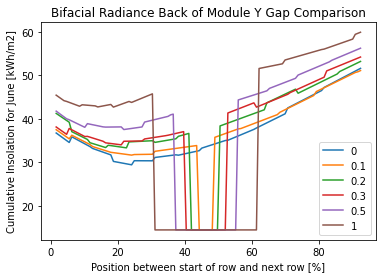

In [185]:
for yg in range (0, len(ygaps)):
    ygap = ygaps[yg]
    from bifacialvf import loadVFresults
    #Change to File Name
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_'+str(ygap)+'_Ground_Analysis_Back.csv'
    print(Radiance_File)
    (data2, metadata) = loadVFresults(Radiance_File)
    
    CW = yl * numpanels_l +(ygap * (numpanels_l-1)) #Collector Width
    pitch = CW/GCR_def
    
    #pitch = CW/GCR
    #print(yinc)
    #print(pitch)
    #length = pitch*nRows+(y* np.cos(np.radians(tilt_def)))+2
    #print(length)
    #yinc = -length/(sensorsy_gb[0]-1)
    #s_point= round(13254 + (pitch/yinc)*-1)
    #start_point = round(13270 + (pitch/yinc))
    #print(pitch)
    #print(yinc)
    #print(round(pitch/yinc))
    
    #Based on calculations, the points in the bifacial radiance file that correspond with the points in the bifacialvf
    # file are (0,-1) to (0,5.06). This is rows 13272 through 13256 (16 points) in the excel file. Will isolate these rows
    #data2.rename(columns={ data2.columns[0]: "x", data2.columns[1]: "y",data2.columns[2]: "z", data2.columns[3]: "mattype",                   #data2.columns[4]: "Wm2Front",}, inplace = True)
    #data_line = data2.iloc[13254:s_point] #Account for the three lines ignored in the loadVFresults command. Don't need them since 
    data_line = data2#.iloc[start_point:13270] #Account for the three lines ignored in the loadVFresults command. Don't need them since 
    #print(data_line)
    #data_line_f=np.flipud(data_line)
    data_line_f = data_line[::-1].reset_index(drop = True) #Flip the column
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Back",}, inplace = True)
    #we're focused on later points.
    #print(data_line_f)
    #print(data_line_f['Wm2Front'].min())

    xstep = (len(data_line_f))
    #print(xstep)
    x_axis = list(range(1,101))
    x_axis_rad = np.linspace(0,100,xstep)
    #print(x_axis_rad)
    #print(x_axis)
    
    yshift = data_line_f['y'] + abs(float(data_line_f['y'].iloc[[0]]))# Shift x_axis so it starts at 0 and not -1
    print(yshift)
    ystep = (yshift/CW)*100

    plt.figure(1)
    #Radiance = plt.plot(x_axis_rad,data_line_f['Wm2Front']/1000, label=GCR)
    Radiance = plt.plot(ystep,data_line_f['Wm2Back']/1000, label=ygap)
    plt.title('Bifacial Radiance Back of Module Y Gap Comparison')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for June [kWh/m2]')
    plt.legend()
    #Q In bifacial Radiacne is (0,0) the middle of the module or the bottom edge

In [175]:
print(data_line_f['y'].iloc[[0]])

0      1.386583
1      1.363285
2      1.339986
3      1.316688
4      1.293390
         ...   
113   -1.246110
114   -1.269408
115   -1.292706
116   -1.316004
117   -1.339302
Name: y, Length: 118, dtype: float64


In [84]:
# Main part of code. I'll test things out below then bring them up here and comment them out
#module = demo.makeModule(name=moduletype, x=x, y=y, xgap=xgap, ygap=ygap)
# Prepare to run for loop of start and end times for May to October
#starttimes =['2005-05-01 1:30:0', '2007-06-01 1:30:0', '2020-07-01 1:30:0', '2020-08-01 1:30:0', '2002-09-01 1:30:0', '1998-10-01 1:30:0']
#endtimes = ['2005-05-31 23:30:0', '2007-06-30 23:30:0','2020-07-31 23:30:0', '2020-08-31 23:30:0', '2002-09-30 23:30:0', '1998-10-31 23:30:0']
#months = ['May','Jun','Jul','Aug','Sep','Oct']
#demo = bifacial_radiance.RadianceObj(sim_general_name,str(testfolder))  
#demo.setGround(albedo)
#for ti in range (0, len(starttimes)):
#    starttime = pd.to_datetime(starttimes[ti])
# #    endtime = pd.to_datetime(endtimes[ti])
#     month = months[ti]
#     demo.readWeatherFile(epwfile, starttime=starttime, endtime=endtime) # Name and path
#     demo.genCumSky()
#     #Generate sky for each month and run emptyscan for each month
#     sim_name = sim_general_name+'_'+month
#     sceneDict = {'tilt':0,'pitch':2,'clearance_height':0.005,'azimuth':180, 'nMods': 1, 'nRows': 1} 
#     scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
#     octfile = demo.makeOct(octname = demo.basename)  
#     analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
#     frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
#     emptyscan = frontscan.copy() 
#     emptyscan['xstart'] = xstart
#     emptyscan['xinc'] = 0
#     emptyscan['sx_xinc'] = xinc
#     emptyscan['ystart'] = ystart
#     emptyscan['yinc'] = yinc
#     emptyscan['zstart'] = 0.05
#     emptyscan['zinc'] = 0
#     emptyscan['orient'] = '0 0 -1'
#     emptybackscan = emptyscan.copy()
#     emptybackscan['orient'] = '0 0 1'
#     analysis.analysis(octfile, name=sim_name+'_EMPTYSCAN', frontscan=emptyscan, backscan=emptybackscan)

#     for az in range (0, len(azimuths)):
#         #Build scene and run raytracing for all 3 azimuths
#         azimuth = azimuths[az]
#         sim_name = sim_general_name+'_'+month+'_az_'+str(round(azimuth,1))
#         sceneDict = {'tilt':tilt,'pitch':pitch,'clearance_height':clearance_height,'azimuth':azimuth,'nMods': nMods,'nRows': nRows}
#         if azimuth == 180:
#             scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
#             octfile = demo.makeOct(demo.getfilelist())  
#             analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
#             frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
#             groundscan = frontscan.copy() 
#             groundscan['xstart'] = xstart
#             groundscan['xinc'] = 0
#             groundscan['sx_xinc'] = xinc
#             groundscan['ystart'] = ystart
#             groundscan['yinc'] = yinc
#             groundscan['zstart'] = 0.05
#             groundscan['zinc'] = 0
#             groundscan['orient'] = '0 0 -1'
#         sceneDict['azimuth'] = azimuth
#         scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
#         octfile = demo.makeOct(demo.getfilelist())
#         frontscan, backscan = analysis.moduleAnalysis(scene=scene, sensorsy=sensorsy_fb, sensorsx = sensorsx_fb)
#         analysis.analysis(octfile, name=sim_name+'_Module_Analysis', frontscan=frontscan, backscan=backscan)
#         analysis.analysis(octfile, name=sim_name+'_Ground_Analysis', frontscan=groundscan, backscan=backscan)
#         #Read each azumith file for Wm2 Front
#         azimuth_s = azimuth_strings[az]
#         file = os.path.join(resultsfolder, 'irr_nespelem_'+month+'_az_'+azimuth_s+'_Ground_Analysis_Front.csv')
#         df2 = pd.read_csv(file)
#         Wm2 = np.asarray(df2['Wm2Front']) 
#         Wms2 = np.reshape(np.ravel(Wm2, order='C'), (122,217), order='F')
#         #Read each empty file for Wm2Front
#         empty_scan = os.path.join(resultsfolder, 'irr_nespelem_'+month+'_EMPTYSCAN.csv')
#         de = pd.read_csv(empty_scan)
#         Wmempty = np.asarray(de['Wm2Front']) 
#         Wms_empty = np.reshape(np.ravel(Wmempty, order='C'), (122,217), order='F')
#         #Calculate Irradiance Facor and plot and save heat map of each month_azumith
#         plt.figure(1)
#         shading = Wms2/Wms_empty
#         fig = plt.imshow(shading, cmap='hot', vmin=np.min(shading).min(), vmax=np.max(shading).max(), interpolation='none', aspect = 'equal')
#         plt.colorbar(label='Irr Factor')
#         plt.title(month+'_Bifacial Irr Factor (az='+azimuth_s+'), in matrix form')
#         fig.axes.get_yaxis().set_visible(False)
#         fig.axes.get_xaxis().set_visible(False)
#         plt.savefig(month+'_Bifacial_az_'+azimuth_s+'.png')
#         plt.clf()
    
        
        





## Plotting attempts. Code from below brought to man code. Everything below is a test

In [ ]:
#test = os.path.join(resultsfolder, 'irr_nespelem_May_az_180_Ground_Analysis_Front_test.csv')
#df = pd.read_csv(test)
#np.reshape(np.ravel(num_array, order='C'), (4,2), order='F')
#Wm = np.asarray(df['Wm2Front']) 
#Wms = np.reshape(np.ravel(Wm, order='C'), (10,15), order='F')
#((np.asarray(df['x'])).reshape(np.ravel(num_arrorder='C'), (15,10), order='F')
#print(Wms)
#fig = plt.imshow(Wms, cmap='hot', vmin=np.min(Wms).min(), vmax=np.max(Wms).max(), interpolation='none', aspect = 'equal')
#result = df.pivot(index='y',columns='x',values='Wm2Front')
#print(result)
#fig2 = plt.imshow(result, cmap='hot', vmin=np.min(result).min(), vmax=np.max(result).max(), interpolation='none', aspect = 'equal')
#plt.colorbar(label='G$_{Ground}$')
#plt.title('May Bifacial (az = 180), in matrix form')
#fig.axes.get_yaxis().set_visible(False)
#fig.axes.get_xaxis().set_visible(False)


In [ ]:
# Create Irradiance HeatMap for May
test2 = os.path.join(resultsfolder, 'irr_nespelem_May_az_180_Ground_Analysis_Front.csv')
df2 = pd.read_csv(test2)
#np.reshape(np.ravel(num_array, order='C'), (4,2), order='F')
Wm2 = np.asarray(df2['Wm2Front']) 
Wms2 = np.reshape(np.ravel(Wm2, order='C'), (122,217), order='F')
#((np.asarray(df['x'])).reshape(np.ravel(num_arrorder='C'), (15,10), order='F')
#print(Wms)
fig = plt.imshow(Wms2, cmap='hot', vmin=np.min(Wms2).min(), vmax=np.max(Wms2).max(), interpolation='none', aspect = 'equal')
#result = df.pivot(index='y',columns='x',values='Wm2Front')
#print(result)
#fig2 = plt.imshow(result, cmap='hot', vmin=np.min(result).min(), vmax=np.max(result).max(), interpolation='none', aspect = 'equal')
plt.colorbar(label='G$_{Ground}$')
plt.title('May Bifacial (az=180), in matrix form')
fig.axes.get_yaxis().set_visible(False)
fig.axes.get_xaxis().set_visible(False)
#plt.savefig('May_Bifacial_az_180.png')

In [ ]:
# For loop creates and saves heat map of irradiance factor for all 12 months and all 3 azimuths per month
for ti in range (0, len(starttimes)):
    starttime = pd.to_datetime(starttimes[ti])
    endtime = pd.to_datetime(endtimes[ti])
    month = months[ti]   
    azimuths_string = ['180','150','210']
    for az in range (0, len(azimuths_string)):
        #Run Build scene and run scans for all 3 azimuths
        azimuth = azimuths_string[az]
        #Read each azumith file for Wm2 Front
        file = os.path.join(resultsfolder, 'irr_nespelem_'+month+'_az_'+azimuth+'_Ground_Analysis_Front.csv')
        df2 = pd.read_csv(file)
        Wm2 = np.asarray(df2['Wm2Front']) 
        Wms2 = np.reshape(np.ravel(Wm2, order='C'), (122,217), order='F')
        #Read each empty file for Wm2Front
        empty_scan = os.path.join(resultsfolder, 'irr_nespelem_EMPTY_'+month+'_EMPTYSCAN.csv')
        de = pd.read_csv(empty_scan)
        Wmempty = np.asarray(de['Wm2Front']) 
        Wms_empty = np.reshape(np.ravel(Wmempty, order='C'), (122,217), order='F')
        #Calculate Irradiance Facor and plot and save heat map of each month_azumith
        plt.figure(4)
        shading = Wms2/Wms_empty
        fig = plt.imshow(shading, cmap='hot', vmin=np.min(shading).min(), vmax=np.max(shading).max(), interpolation='none', aspect = 'equal')
        plt.colorbar(label='Irr Factor')
        plt.title(month+'_Bifacial Irr Factor (az='+azimuth+'), in matrix form')
        fig.axes.get_yaxis().set_visible(False)
        fig.axes.get_xaxis().set_visible(False)
        plt.savefig(month+'_Bifacial_az_'+azimuth+'.png')
        plt.clf()
    

In [ ]:
#nespelem_ground_irrad_150 = data150g['Wm2Front'][0]
#nespelem_ground_irrad_180 = data180g['Wm2Front'][0]
#nespelem_ground_irrad_210 = data210g['Wm2Front'][0]
#print(nespelem_ground_irrad_150, nespelem_ground_irrad_180, nespelem_ground_irrad_210)

## 2. Calculate GHI for Comparisons

### Option : Raytrace of Empty Field for Irradiance Factor Calculations

In [ ]:
# Prepare to run for loop of start and end times for May to October
#starttimes =['2005-05-01 1:30:0', '2007-06-01 1:30:0', '2020-07-01 1:30:0', '2020-08-01 1:30:0', '2002-09-01 1:30:0', '1998-10-01 1:30:0']
#endtimes = ['2005-05-31 23:30:0', '2007-06-30 23:30:0','2020-07-31 23:30:0', '2020-08-31 23:30:0', '2002-09-30 23:30:0', '1998-10-31 23:30:0']
#months = ['May','Jun','Jul','Aug','Sep','Oct']
#demo = bifacial_radiance.RadianceObj(sim_general_name,str(testfolder))  
#demo.setGround(albedo)
demo.makeModule(name=moduletype, x=0.001, y=0.001, xgap = 0)
for ti in range (0, len(starttimes)):
    starttime = pd.to_datetime(starttimes[ti])
    endtime = pd.to_datetime(endtimes[ti])
    month = months[ti]
    demo.readWeatherFile(epwfile, starttime=starttime, endtime=endtime) # Name and path
    demo.genCumSky() 

    sim_name = sim_general_name+'_'+ month
    sceneDict = {'tilt':0,'pitch':2,'clearance_height':0.005,'azimuth':180, 'nMods': 1, 'nRows': 1} 
    scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
    octfile = demo.makeOct(octname = demo.basename)  
    analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
    frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
    emptyscan = frontscan.copy() 
    emptyscan['xstart'] = xstart
    emptyscan['xinc'] = 0
    emptyscan['sx_xinc'] = xinc
    emptyscan['ystart'] = ystart
    emptyscan['yinc'] = yinc
    emptyscan['zstart'] = 0.05
    emptyscan['zinc'] = 0
    emptyscan['orient'] = '0 0 -1'
    emptybackscan = emptyscan.copy()
    emptybackscan['orient'] = '0 0 1'
    analysis.analysis(octfile, name=sim_name+'_EMPTYSCAN', frontscan=emptyscan, backscan=emptybackscan)


In [ ]:
empty_test = os.path.join(resultsfolder, 'irr_nespelem_EMPTY_May_EMPTYSCAN.csv')
de = pd.read_csv(empty_test)
#np.reshape(np.ravel(num_array, order='C'), (4,2), order='F')
Wmempty = np.asarray(de['Wm2Front']) 
Wms_empty = np.reshape(np.ravel(Wmempty, order='C'), (122,217), order='F')
#((np.asarray(df['x'])).reshape(np.ravel(num_arrorder='C'), (15,10), order='F')
#print(Wms)
plt.figure(1)
fig = plt.imshow(Wms_empty, cmap='hot', vmin=np.min(Wms_empty).min(), vmax=np.max(Wms_empty).max(), interpolation='none', aspect = 'equal')
#result = df.pivot(index='y',columns='x',values='Wm2Front')
#print(result)
#fig2 = plt.imshow(result, cmap='hot', vmin=np.min(result).min(), vmax=np.max(result).max(), interpolation='none', aspect = 'equal')
plt.colorbar(label='G$_{Ground}$')
plt.title('May Bifacial Empty (az=180), in matrix form')
fig.axes.get_yaxis().set_visible(False)
fig.axes.get_xaxis().set_visible(False)
#plt.savefig('May_Bifacial_az_180.png')

month = 'May'
plt.figure(2)
shading = Wms2/Wmse
print(shading)
fig = plt.imshow(shading, cmap='hot', vmin=np.min(shading).min(), vmax=np.max(shading).max(), interpolation='none', aspect = 'equal')
plt.colorbar(label='Irr Factor')
plt.title('May Bifacial Irr Factor (az=180), in matrix form')
fig.axes.get_yaxis().set_visible(False)
fig.axes.get_xaxis().set_visible(False)
#plt.savefig('May_Bifacial_az_180.png')



In [ ]:
#resname = os.path.join(resultsfolder, 'irr__EMPTYSCAN.csv')
#data = pd.read_csv(resname)
#nespelem_year_empty = data['Wm2Front'][0]
#print("Empty field YEARLY TOTAL Wh/m2:", nespelem_year_empty)

#shading = np.array([nespelem_ground_irrad_150/nespelem_year_empty,nespelem_ground_irrad_180/nespelem_year_empty,nespelem_ground_irrad_210/nespelem_year_empty])
#print("Percent Unshaded at 150, 180 and 210 degree azimuths",shading)

<a id='step5b'></a>

<a id='step5c'></a>